In [1]:

#package imports
# UTILS
from datetime import datetime,time,timedelta
import os
## PLOT
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
## MATH
from scipy.optimize import curve_fit as curvefit
import numpy as np



## ASTROPY
from astropy.io import fits
from astropy.time.core import Time, TimeDelta
from astropy.table import Table
import astropy.units as u

import ancillary_functions as af
import pixel_functions as pf

#  Extract Pixel data files 

In [2]:
# L1 pixel data
pixel_file = "data/solo_L1_stix-sci-xray-cpd_20210717T043515-20210717T053459_V02_2107170037-55970.fits"
# Background file
bkg_file = "data/solo_L1_stix-sci-xray-cpd_20210716T230015-20210717T003515_V01_2107160030-55985.fits"

In [3]:
pixel_hdulist = fits.open(pixel_file)
pixel_header = pixel_hdulist[0].header
af.print_obs_info(pixel_header)

Observatory: Solar Orbiter
Instrument: STIX
Observation time:
 from: 2021-07-17T04:35:15.722
 to: 2021-07-17T05:34:59.328
Distance s/c - sun: 0.8507424958937714 AU
Time delay s/c - sun: 424.5245752637037 s


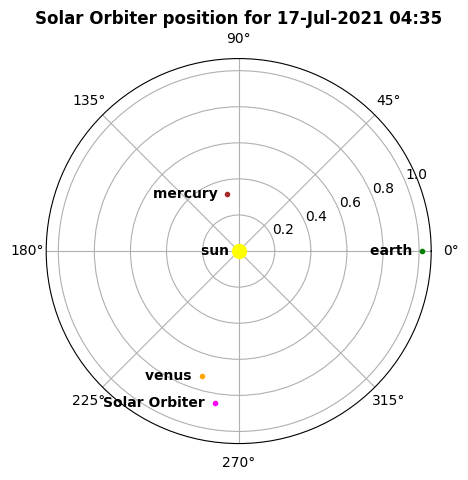

In [4]:
af.plot_sc_position(pixel_header)

In [5]:
# extract the info of the energy channels
pixel_energies = Table(pixel_hdulist[4].data)
pixel_energies

channel,e_low,e_high
uint8,float32,float32
0,0.0,4.0
1,4.0,5.0
2,5.0,6.0
3,6.0,7.0
4,7.0,8.0
5,8.0,9.0
...,...,...
25,63.0,70.0
26,70.0,76.0


In [6]:
# get counts and time data
pixeldata = Table(pixel_hdulist[2].data)

The first thing we need to take into account is that **the shape of the counts array is different** as it has two additional dimensions **compared to the spectrogram** files we used before: the **detector** and **pixel** dimensions. To have a better comprehension of the data and how it can be used for imaging, a good first step is to understand the data collection process and the instrument properties.

### Imaging with STIX

**STIX is composed of 32 detectors :30 used for imaging (visibilities), the Coarse Flare Locator (CFL) and the background detector (BKG). Each of the 32 detectors has 12 pixels and each pixel has the 32 energy channels** we used in the previous session. The spectrogram files we know from our previous work can be obtained by summing the counts per energy bin across al detectors and all pixels, losing these dimensions as they are not needed for spectroscopy. 

On the other hand, **the imaging process uses the flux in the different pixels of each detector to reconstruct the visibilities** (Fourier components) and create the images. Let's remember that, given the different scales and orientations of the Moiré patterns (grids) in front of the detectors, **the location and shape of the X-ray source can affect the relative flux in the pixels differently for each detector**. By using only the counts of selected energy channels is also possible to image the sources in different energy regimes.  


In [7]:
print("counts array shape:", np.shape(pixeldata["counts"]))
print("time array shape:", np.shape(pixeldata["time"]))
print("Energy channels:", len(pixel_energies))

counts array shape: (165, 32, 12, 32)
time array shape: (165,)
Energy channels: 32


Remember, in the previous session we were using spectrogram files with the accumulated counts per energy channel across all detectors. **Now we are dealing with more information** so it's worth saying that we should treat carefully the different "dimensions" of the information we are given. For instance: for each timestep we have a counts value associated for each energy bin in each pixel of each detector. from the print we did above, we see that the counts array is ordered such that the axes are (in order): time, detector, pixel, energy bin. Having this in mind, let's **estimate the count rate** by dividing the counts in each time bin by the time bin length "timedel" (seconds).

In [8]:
# we want an array with the same shape as the counts array
cts_sec_array = np.zeros(np.shape(pixeldata["counts"]))

# for each timestep (axis 0)
for t in range(len(pixeldata["time"])):
    # the 3 dimesional counts matrix associated with the
    # timestep is divided by the timestep length in seconds
    t_del = pixeldata["timedel"][t]/100
    cts_sec_array[t,:,:,:] = pixeldata["counts"][t,:,:,:]/t_del
# append count rate to the data Table
pixeldata["cts_per_sec"] = cts_sec_array
    

In [9]:
# since the time is given in seconds after the observation begins( at t_O),
# the time axis is t = t0 + Dt(s) 
data_time = Time(pixel_header['date-obs']) + TimeDelta(pixeldata['time'] * u.cs)

#use this other line instead if the above doesnt work
# the time axis is t = t0 + Dt(s) 
#data_time = Time(pixel_header['date_obs']) + TimeDelta(pixeldata['time'] * u.s)

pixeldata["datetime"] = data_time

In [10]:
pixel_energies

channel,e_low,e_high
uint8,float32,float32
0,0.0,4.0
1,4.0,5.0
2,5.0,6.0
3,6.0,7.0
4,7.0,8.0
5,8.0,9.0
...,...,...
25,63.0,70.0
26,70.0,76.0


We are still dealing with the same **32 energy channels** as before, but this time we are handling the information of each pixel. The **32 subcollimators** in STIX are enumerated as shown in the left side of figure 1, where the CFL and BKG are subcollimator 9 and 10, respectively. **Take into account** that the indexes on python start from 0, thus the enumeration is going from 0 to 31, being the CLF and BKG indexed as 8 and 9. The other 30 subcollimators are used for imaging and each one is associated with a **Moirée pattern** sensible to a specific angular resolution (or scale) and orientation (see the [STIX Instrument paper](https://ui.adsabs.harvard.edu/link_gateway/2020A%26A...642A..15K/PUB_PDF), section 4.2). The subcollimators are grouped in 10 grids (10 different resolutions), each grid with 3 subcollimators corresponding to 3 different orientations for each scale.

The role of the **Coarse Flare Locator** is to provide a real-time coarse, but unambiguous, flare location relative to the STIX optical axis. The rear grid window of the CFL is open and the front grid window has a “H-shaped” pattern (as seen in the figure) that enables each **potential flare location** to provide the CFL detector with a unique illumination pattern on the detector.


On the other hand, the “**BKG**” subcollimator, monitors both the X-ray background and the intense unattenuated low-
energy flux from large flares. The BKG subcollimator is never covered by the attenuator and, as needed during large flares, successive pixels in this detector can be automatically disabled in order to **monitor both background and incident flux** while avoiding excessive count rates.

##### Fig 1.

![COLLIMAORS_DETECTOR](data/collimators_detector.png)

The detector of **each subcollimator has 12 pixels**, enumerated from 0 to 11 where the last 4 indexes correspond to the small pixels in the central row. As the frontal grids create a Moirée pattern in the detector, the data from each subcollimator can be interpreted as a measurement of a specific **Fourier component (visibilities)** of the source angular distribution. To estimate such visibilities the counts on four "large" pixels are accumulated as shown below in the figure on the right (A, B, C, D). The **amplitude** of each visibility (depending on the scale associated with the collimator) is proportional to its **total flux**, but also depends on the size and shape
of the source. For a simple source, the ratio of visibility amplitude to total flux can provide a measure of its size, while the visibility **phase** depends on the source location and/or its morphology.

### Quicklooks  - plotting pixels for specific subcollimators and energy channels
Let's explore first the time profile of the count rate per pixel for a given energy channel and detector. For this, we might choose a subcollimator and an energy channel to plot (ideally one with enough flare counts).  

Text(0.5, 0, 'Observation Time [@SolO]: 17-Jul-2021 04:35:25')

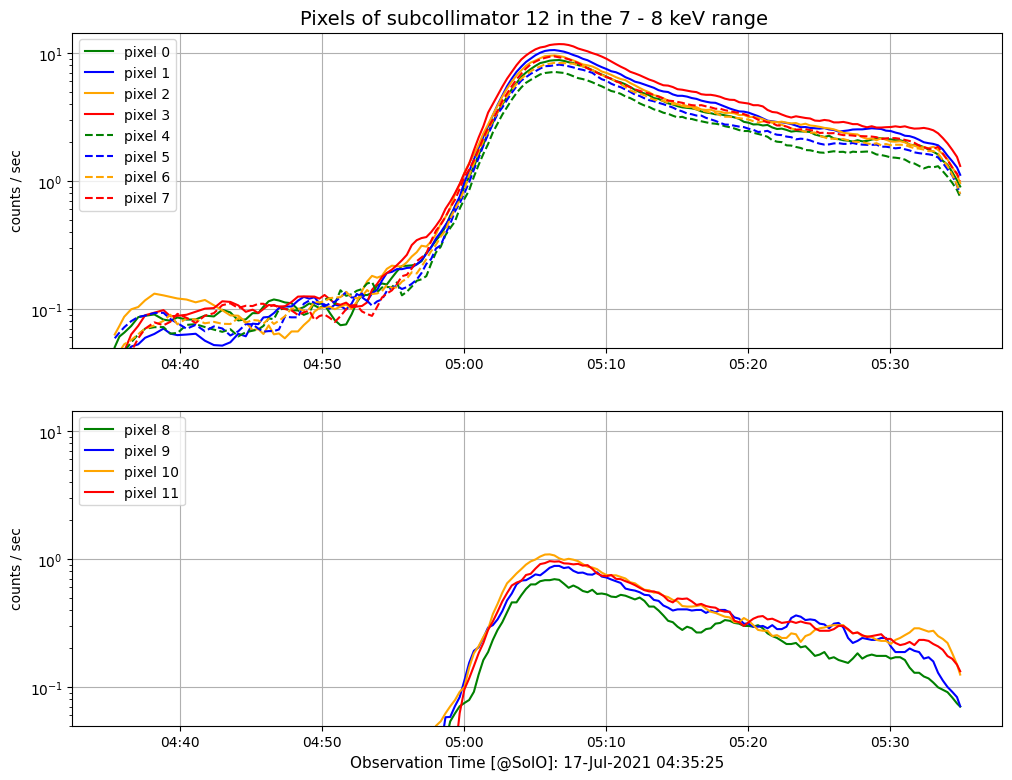

In [11]:
# ACTIVITY define the energy channel with the channel number 
energy_channel = 4

# select a subcollimator:
#     subcollimator 8 is the Coarse Flare Locator (CLF)
#     subcollimator 9 is the Background (BKG)
detector = 12

# smooth the curves with a moving average (temporal integration)
# select the number of points you want to use (more points = softer function)
smooth_pts = 12
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =



#define the energy bundaries label for rhe selected energy channel
e_bounds = f"{round(pixel_energies['e_low'][energy_channel])} - {round(pixel_energies['e_high'][energy_channel])} keV"
# max value in the countrate for the selected detector and energy channel (to define plot limits)
maxval = np.max(pixeldata["cts_per_sec"][:,detector,:,energy_channel])

# smoothing function - moving average
def smooth(y,pts):
    one = np.ones(pts)/pts
    return np.convolve(y,one,mode="same")

# plotting colors
colors = ["green","blue","orange","red"]

#PLOT
plt.figure(figsize=(12,9))
ax=plt.subplot(211)
plt.title(f"Pixels of subcollimator {detector} in the {e_bounds} range ",fontsize=14)

# The first 8 pixels
#     O-3 are large pixels on top row (solid line)
#     4-7 are large pixels on bottom row (dashed line)
for  i in range(8):
    ls = "-" if i<4 else "--"
    col = colors[i] if i<4 else colors[i-4]
    pixl_plot = np.array(pixeldata["cts_per_sec"][:,detector,i,energy_channel])
    plt.plot(data_time.datetime,smooth(pixl_plot,smooth_pts),label=f"pixel {i}",ls=ls,c=col)
plt.legend(loc=2)
plt.ylim(0.05,1.1*maxval)
plt.yscale("log")
plt.grid()
plt.ylabel('counts / sec')
# format the date axis (%H: hour,%M: minute,%H: second)
# you might use your prefered format
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)

ax2=plt.subplot(212)

# The last 4 pixels
#     8-11 are small pixels on center row (solid line)
for  i in range(8,12):
    pixl_plot = np.array(pixeldata["cts_per_sec"][:,detector,i,energy_channel])
    plt.plot(data_time.datetime,smooth(pixl_plot,smooth_pts),label=f"pixel {i}",color=colors[i-8])
plt.legend(loc=2)

# define Y limits of plot, log scale and labels
plt.ylim(0.05,1.1*maxval)
plt.yscale("log")
plt.grid()
plt.ylabel('counts / sec')
# format the date axis (%H: hour,%M: minute,%H: second)
# you might use your prefered format
myFmt = DateFormatter("%H:%M")
ax2.xaxis.set_major_formatter(myFmt)
plt.xlabel("Observation Time [@SolO]: "+(data_time[0].datetime).strftime('%d-%b-%Y %H:%M:%S'),fontsize=11)


The big pixels (indexes 0 to 7) and small pixels (8 to 11) are plotted apart, conserving the color codes for the large pixels ABCD presented  previously in figure 1. The top pixel row (0 to 3) is represented with a solid line (top panel) while the lower pixel row (4 to 7) uses a dashed line. As expected, the small pixels have a lower count rate due to their smaller area.

#### To think about....
* For a given large pixel ABCD, do the top and bottom pixels have similar curves? Is this dependent on something else (subcollimator, energy channel, smoothing, etc)? 
* How are the lightcurves of the BKG and CFL collimators copared to the other 30 used for visibilities? 
* Given the way that STIX uses the grids and Moirée patterns to make images, How can you interpret the fact that the relative count rate between two different large pixels ABCD is changing with time (in other words, curves with different colors don't increase/decrease togehter in unison)?

### Comapring between pixels
The definition of the large ABCD pixels is such that they are sensible the modulation caused the Moiree pattern of the front grids (See figure 6 in the  [STIX Instrument paper](https://ui.adsabs.harvard.edu/link_gateway/2020A%26A...642A..15K/PUB_PDF)). The fringe patttern varies "horizontally" between ABCD pixels but is not expected to change in the vertical direction i.e. bottom and top pixels of the same large ABCD pixels have similar accumulated counts. Moreover, each subpixel of the large pixels is, in theory, exposed to the same photon flux (the flux only changes from one large ABCD pixel to another, but not within subpixels of the same group), thus the accumulated counts per pixel deppend on the integration time and the pixel area (and the nature of the flare event, of course). 
Now, given that the area of the pixels is known (9.6 mm$^2$ for the larger pixels and 1.0 mm$^2$ for the small ones), it might be interesting to look at the relation between the ratio of the areas of small and big pixels(for each large ABCD pixel), and the ratio of count rates observed. 

/tmp/ipykernel_1224736/2224312944.py:44: RuntimeWarning: divide by zero encountered in divide
  toplot = smallpix/pixl_plot
/tmp/ipykernel_1224736/2224312944.py:44: RuntimeWarning: invalid value encountered in divide
  toplot = smallpix/pixl_plot


Text(0.5, 0, 'Observation Time [@SolO]: 17-Jul-2021 04:35:25')

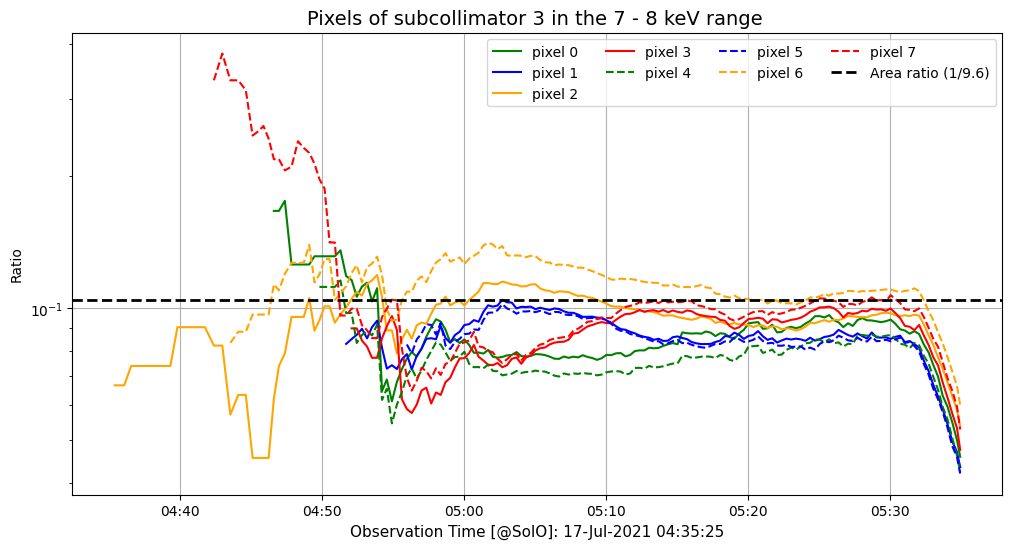

In [13]:
# ACTIVITY define the energy channel with the channel number 
energy_channel = 4

# select a subcollimator:
#     subcollimator 8 is the Coarse Flare Locator (CLF)
#     subcollimator 9 is the Background (BKG)
detector = 3

# smooth the curves with a moving average (temporal integration)
# select the number of points you want to use (more points = softer function)
smooth_pts = 20


small_pixel_area = 1 #mm2
big_pixel_area = 9.6 #mm2


# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =



#define the energy bundaries label for rhe selected energy channel
e_bounds = f"{round(pixel_energies['e_low'][energy_channel])} - {round(pixel_energies['e_high'][energy_channel])} keV"
# max value in the countrate for the selected detector and energy channel (to define plot limits)
maxval = np.max(pixeldata["cts_per_sec"][:,detector,:,energy_channel])


#PLOT
plt.figure(figsize=(12,6))
ax=plt.subplot(111)
plt.title(f"Pixels of subcollimator {detector} in the {e_bounds} range ",fontsize=14)

# The first 8 pixels
#     O-3 are large pixels on top row (solid line)
#     4-7 are large pixels on bottom row (dashed line)
for  i in range(8):
    ls = "-" if i<4 else "--"
    small_pix_idx = 8+(i%4)
    col = colors[i] if i<4 else colors[i-4]
    
    pixl_plot = np.array(pixeldata["cts_per_sec"][:,detector,i,energy_channel])
    smallpix =  np.array(pixeldata["cts_per_sec"][:,detector,small_pix_idx,energy_channel])
    
    toplot = smallpix/pixl_plot
    
    plt.plot(data_time.datetime,smooth(toplot,smooth_pts),label=f"pixel {i}",ls=ls,c=col)
# paint line in the value of area ratio
plt.axhline(small_pixel_area/big_pixel_area,c="k",ls="--",lw=2,label="Area ratio (1/9.6)")
plt.legend(loc=0,ncol=4)

plt.yscale("log")
plt.grid()
plt.ylabel('Ratio')
# format the date axis (%H: hour,%M: minute,%H: second)
# you might use your prefered format
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)

plt.xlabel("Observation Time [@SolO]: "+(data_time[0].datetime).strftime('%d-%b-%Y %H:%M:%S'),fontsize=11)



**Note:** you might see a warning regarding division by zero.  Take into account that having 0 counts is a possibility for all pixels.


### to think about ...
* What can you say about the ralation between the Area ratio and the counts ratio for different collimators (keeping the same energy channel)? 
* Based on the observations you made in the previous question, do they change if you change the energy channel? how?

## Observing modulation in the different subcollimators

 We want to see the spatial modulation in each detector caused by the flare event. From the quicklook we got an intuition on how this modulaiton evolves in time, so for this exercise is necessary to define an interesting time and energy interval to observe how the accumulated counts are distributed among all pixels. 
 
 The subcollimators are grouped by angular resolution in groups of 3 orientations: the different groups are sensible to different sizes of the source, thus expecting higher modulation in the groups with an angular resolution similar to the observed extension of the X-ray source. We will observe this by plotting the accumulated counts per pixel ABCD for all the subcollimators and comparing the different scales. 
 
 #### Total flux and check 
Is intuitive that by adding the accumulated counts in all 4 ABCD pixels we obtain the total flux in the detector, so that 

Flux = A + B + C + D

This flux is used to obtain the visibility amplitude as both quantities are proportional. Recall that the ratio of visibility amplitude to total flux can provide a measure of The source size.The visibility (complex) is defined as:

Imag(V) = D - B
Real(V) = C - A

Where the visibility amplitude is |V|.

On the other hand, because of the properties of the modulation caused by the Moiree pattern, is possible to estimate a cross-check that is independent of the visibility, flux, and background.

 A + C = B + D 

In [14]:
# ACTIVITY - FILL the following dictionary using the information given in 
# the course and the information available in the STIX paper


index_dict = {
    "pixels":{
        "A":[0,4,8],
        "B":[1,5,9],
        "C":[2,6,10],
        "D":[3,7,11]
    },
    "detector_grids":{
        "1":[10,12,17],
        "2":[11,18,16],
        "3":[6,28,0],
        "4":[24,4,22],
        "5":[5,29,1],
        "6":[14,26,30],
        "7":[23,7,27],
        "8":[20,25,3],
        "9":[15,13,31],
        "10":[2,19,21],
        "CLF":8,
        "BKG":9
    },
    "detector_grids_orientation":{
        "1":[150,90,30],
        "2":[130,70,10],
        "3":[110,50,170],
        "4":[90,30,150],
        "5":[70,10,130],
        "6":[50,170,110],
        "7":[30,150,90],
        "8":[10,130,70],
        "9":[170,110,50],
        "10":[150,90,30]
    },
    
    "detector_grids_resolution":{
        "1":7.1,
        "2":10.2,
        "3":14.6,
        "4":20.9,
        "5":29.8,
        "6":42.7,
        "7":61.0,
        "8":87.3,
        "9":124.9,
        "10":178.6, 
    }
    
}



**Note:** In the cell below we'll define the functions we are going to use for plotting the flux modulation in pixels ABCD. There's no need to change anything in the script, however the code is commented so you can follow the process.

In [15]:
def evaluate_flux_check(A,B,C,D):
    # given ABCD define the flux
    flux  = A + B + C + D
    # we want a check metric that is zero if the check is valid
    check = A + C - B - D
    return flux,check 

In [16]:



# estimation of the accumulated counts (ABCD) for a specific subcollimator, energy range and time range
def estimate_accumulated_counts(data,energies,subcollimator,energy_range,time_range):
    
    # GET indexes of time interval
    # transform time range into datetime format
    time_range = [datetime.strptime(x,"%Y-%m-%d %H:%M:%S") for x in time_range]
    # index range
    t_range = np.where(np.logical_and(data["datetime"]> time_range[0] , data["datetime"]<= time_range[1]))[0]
    # get index of start and end of interval
    t_min,t_max = t_range[0],t_range[-1]+1
    if(t_min == t_max):
        t_max = t_min+1
    
    #GET indexes of energy range
    # index range
    bin_range = np.where(np.logical_and(energies["e_low"]>= energy_range[0] , energies["e_high"]<= energy_range[1]))[0] 
    # get start and end energy bin index
    idx_emin, idx_emax = bin_range[0],bin_range[-1]+1    
    if(idx_emin==idx_emax):
        idx_emax=idx_emin+1
    
    # counts array to use
    cts = data["cts_per_sec"]
    # directory containing the pixel indexes
    pxl_indx = index_dict["pixels"]
    
    # accumulating counts
    A = np.sum(cts[t_min:t_max,subcollimator,pxl_indx["A"],idx_emin:idx_emax])
    B = np.sum(cts[t_min:t_max,subcollimator,pxl_indx["B"],idx_emin:idx_emax])
    C = np.sum(cts[t_min:t_max,subcollimator,pxl_indx["C"],idx_emin:idx_emax])
    D = np.sum(cts[t_min:t_max,subcollimator,pxl_indx["D"],idx_emin:idx_emax])
    
    # estimating total flux and check
    # The check is: A+C=B+D so to validate the check A+C-B-D has to be close to Zero.
    # thr total flux is used for later normalization
    flux,check = evaluate_flux_check(A,B,C,D)
    
    
    real_comp = C-A
    imag_comp = D-B
    
    v = real_comp + imag_comp*1j
    v_mag = np.abs(v)
    
    

    
    return_dict = {
        "A":A,
        "B":B,
        "C":C,
        "D":D,
        "flux":flux,
        "check":check,
        "v":v
    }
    return return_dict

def create_modulation_data(data,energies,energy_range,time_range):
    
    
    # store visibilities (return them at the end to make the visibilites plot)
    mod_data = {}
    # for each detector grid
    for grid in range(10):

        # get grid indexes
        grid_subc = index_dict["detector_grids"][str(grid+1)]
        
        # for each subcollimator (3 per grid)
        mod_data[str(grid+1)]={}
        for i in range(3):
            # select subcollimator, select column and add axes
            subc = grid_subc[i]
            # get accumulated counts, flux and check for this subcollimator
            acc_counts_dict = estimate_accumulated_counts(data,energies,subc,energy_range,time_range)
            
            # get visibilities

            mod_data[str(grid+1)][str(subc+1)]=acc_counts_dict
    mod_data["time_range"]=time_range
    mod_data["energy_range"]=energy_range
    return mod_data
            
def plot_modulation_data(mod_data):
    
    time_range = mod_data["time_range"]
    energy_range = mod_data["energy_range"]
    


    fig = plt.figure(figsize=(20,15))
    #plot fontsize
    plt.rcParams.update({'font.size': 14})
    #
    plt.suptitle(f"Accumulated Counts ({energy_range[0]} - {energy_range[1]} kev)\n{time_range[0]} to {time_range[1]}",
                fontsize=17)
    #store axes here
    axes = []
    
    # 10 grids (30 visibilities)
    # one row = 2 grids, each grid with 3 comumns + space in middle column
    rows = 5
    cols = 7
    # for each detector grid
    for grid in range(10):
        gridname=str(grid+1)
        # decide wether is  in the left or right half of the plot
        col0 = 0 if grid<=4 else 4
        # decide the row
        row = grid%5
        # get grid indexes
        grid_subc = index_dict["detector_grids"][gridname]
        # get grid properties
        grid_scale = index_dict["detector_grids_resolution"][gridname]
        grid_rot = index_dict["detector_grids_orientation"][gridname]
        # for each subcollimator (3 per grid)  
        for i in range(3):
            # select subcollimator, select column and add axes
            subc = grid_subc[i]
            subcname=str(subc+1)
            
            subc_rot = grid_rot[i]
            col = col0+i
            
            axes.append(plt.subplot2grid((rows, cols), (row, col)))
            # get accumulated counts, flux and check for this subcollimator
            acc_counts_dict = mod_data[gridname][subcname]
            # get visibilities
           
            
            abcd = [acc_counts_dict["A"],acc_counts_dict["B"],acc_counts_dict["C"],acc_counts_dict["D"]]
            # NORMALIZE ABCD by the total flux 
            abcd = np.array(abcd)/acc_counts_dict["flux"]
            xplot = [0,1,2,3]
            # add y label only to first subcollimator of each grid, otherwise remove y ticks
            if(i==0):
                axes[-1].set_ylabel(f"Grid {grid+1}\n {grid_scale} arcsec",fontsize=14)
            else:
                axes[-1].set_yticks([])

            # plot and scatter ABCD
            axes[-1].plot(xplot,abcd,c="k")
            axes[-1].scatter(xplot,abcd,c="k")
            
            # label subcollimator
            axes[-1].text(0,0.45,f"Subcollimator {subc+1}",fontsize=14)
            axes[-1].text(0,0.39,f"{subc_rot}°",fontsize=14)
            
            # display flux
            axes[-1].text(0,0.03,f"Flux = {round(acc_counts_dict['flux'])}",fontsize=13)
            # display check A+C-B-D normalized by flux (remember that A+C = B+D is the check)
            axes[-1].text(0,0.07,f"A+C-B-D = {round(acc_counts_dict['check']/acc_counts_dict['flux'],2)}",fontsize=13)
            
            #replace X ticks
            axes[-1].set_xticks(xplot)
            axes[-1].set_xticklabels(["A","B","C","D"])
            
            # restrict y limits
            axes[-1].set_ylim(0,0.5)
   
            
def plot_visibilities(mod_data_dicts,normed=True):
    
    if(type(mod_data_dicts)==dict):
        mod_data_dicts = [mod_data_dicts]
        
    lcolors = ["red","green","blue","orange"]
    
    
    plt.figure(figsize=(5,5))
    
    
    
    for idx in range(len(mod_data_dicts)):
        v = mod_data_dicts[idx] 
        er = v["energy_range"]
        
        
        tr = [datetime.strptime(x,"%Y-%m-%d %H:%M:%S") for x in  v["time_range"]]
        duration = (tr[1]-tr[0]).seconds
        
        tr = [datetime.strftime(x,"%H:%M:%S") for x in  tr]
        x = []
        y = []
        avg = []

        for grid in range(10):
            gridname = str(grid+1)
            resolution = index_dict["detector_grids_resolution"][gridname]
            grid_mod = v[gridname]
            for colname in list(grid_mod.keys()):
                
                visib = grid_mod[colname]["v"]
                flux = grid_mod[colname]["flux"]
                if(normed):
                    visib = visib/flux
                v_amp = np.abs(visib)
                

                x.append(1/(resolution**2))
                y.append(v_amp)
            avg.append(np.mean(y[-3:]))
        label = f"{er[0]}-{er[1]} keV\n{tr[0]} to {tr[1]} ({int(duration)} seconds)"
        plt.scatter(x,y,c=lcolors[idx],marker="x",label=label)
        plt.plot(x[::3],avg,c=lcolors[idx],lw=1,alpha=0.5)
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(loc="center left",bbox_to_anchor=(1, 0.5))
    
    plt.xlabel("1/resolution$^2$")
    plt.ylabel("Visibility amplitude")
    
    
    plt.grid()
            



#### Choose a time interval 
Define the time interval you are intereted in (for which counts are integrated). Is recommended to use the same criteria we had for choosing a time interval for spectroscopy. In this case we are aiming for interval durations in the range  ~40s to ~100s.

In [17]:
# remember to use the same date format and to have the dates in chronological order
time_interval = ["2021-07-17 05:02:30","2021-07-17 05:04:30"]
#time_interval = ["YYYY-MM-DD hh:mm:ss","YYYY-MM-DD hh:mm:ss"]

#### Choose an energy range
Define the energy range you are intereted in (for which counts are integrated). Be wise to choose an energy interval with enough counts within the time interval you chose before, but also consider that the spatial properties of the X-ray of the source change depending on the energy regime you observe

In [18]:
mod_energy_range = [12,18]

Plot to observe the chosen itnervals

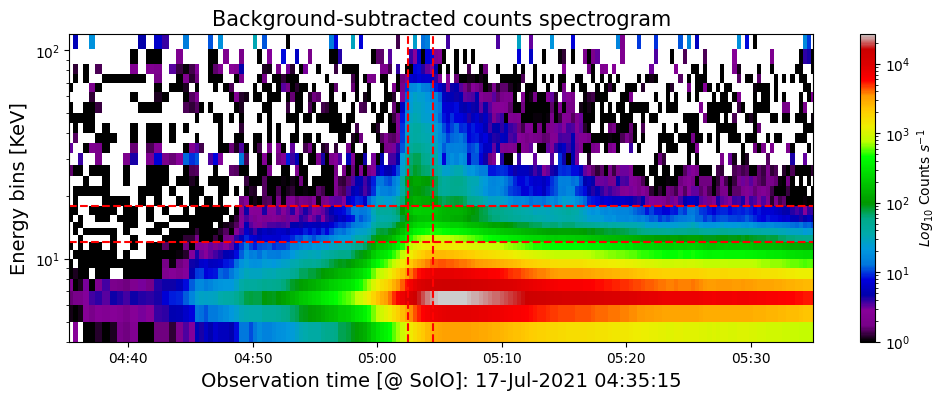

In [19]:
# ACTIVITY - use the  pf.plot_spectrogram_pixel function to help your time  interval decision*
tables = pf.remove_bkg_pixel(pixel_file,bkg_file)
pf.plot_spectrogram_pixel(*tables,energy_range=[4,120],corrected=True,markers=time_interval)
plt.yscale("log")
plt.axhline(mod_energy_range[0],c="red",ls="--")
plt.axhline(mod_energy_range[1],c="red",ls="--")

### Plottting the modulation
Lets plot the counts accumulated in the large ABCD pixels for all subcollimators. By using the `create_modulation_data` function, the estimation of accumulated counts in ABCD is done for every subcollimator and stored in an object (return of the function). The `plot_modulation_data` function will let you plot these accumulated counts (Normalized using the total flux) along with the flux and check values.

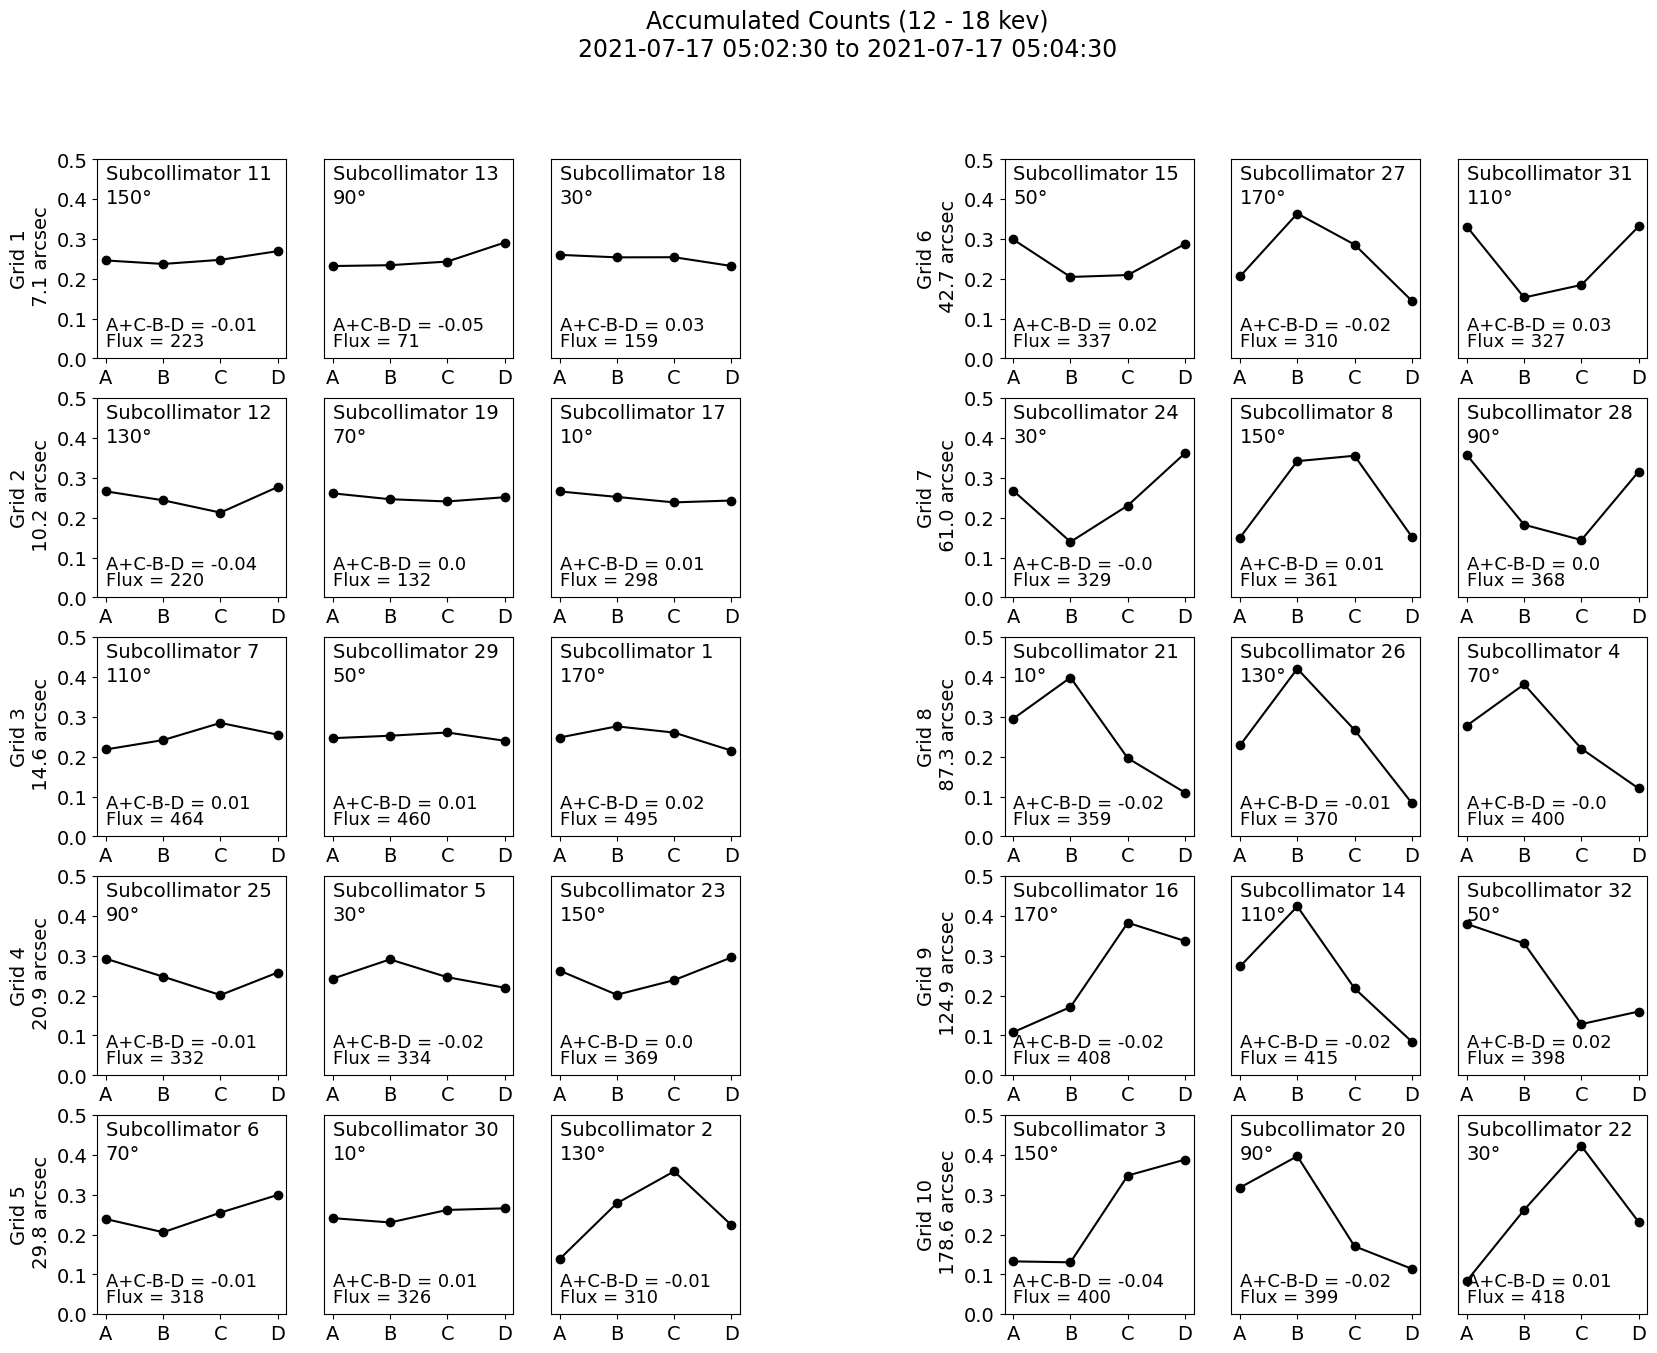

In [20]:
mod_data = create_modulation_data(pixeldata,pixel_energies,mod_energy_range,time_interval)
plot_modulation_data(mod_data)

#### To think about...
* which scales present more modulation? is there a pattern relative to the scale? 
* Are all the check values equal to zero? if not, are these values closed to zero?  

### Visibility amplitude
Lets plot the Visibility amplitude for each angular resolution. With the function `plot_visibilities` you can plot the visibility amplitudes vs. 1/r² where r is the colllimator resolution. Let's recall that the visibility amlplitude normalized by the total flux can provide a good scenario to compare the subcollimator responses at different scales. 

To start let's plot the visibility amplitudes for the time and energy range you chose.

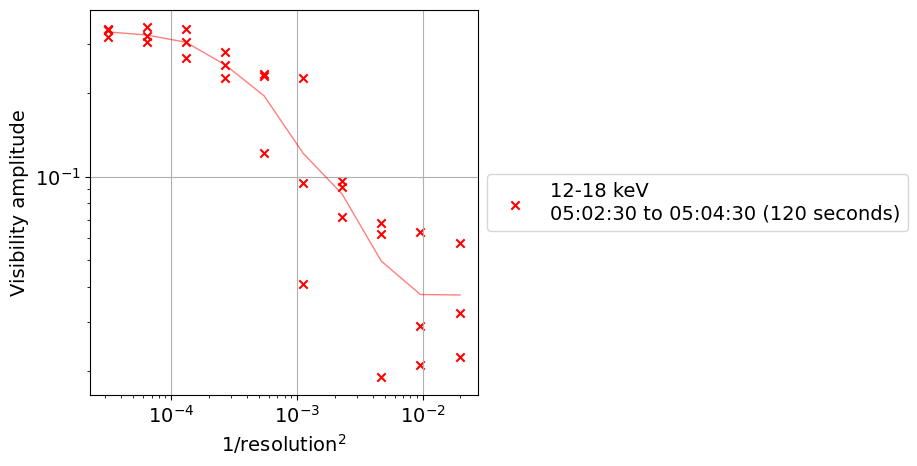

In [21]:
plot_visibilities(mod_data)

### Comparing energy ranges
It's interesting to compare different energy ranges for a fixed time interval. Since for a simple source the ratio of visibility amplitude to total flux can provide an estimate for the size, we can use this to have a rough idea of the size of the sources at different energy regimes. 

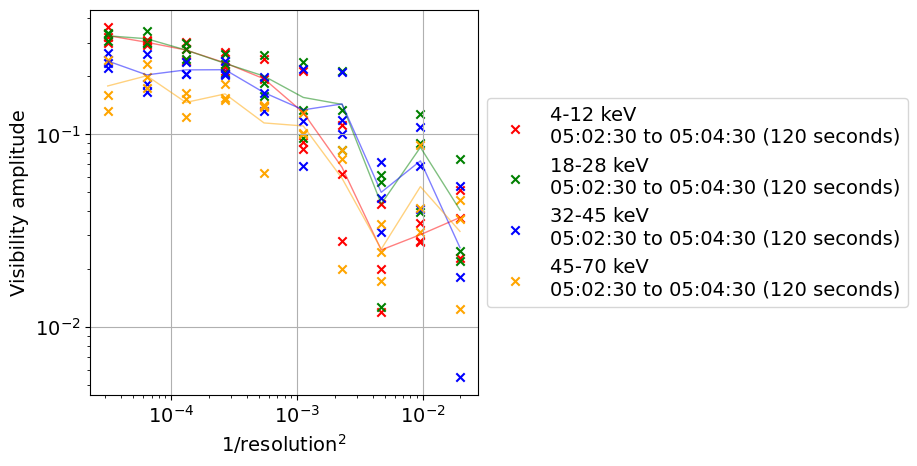

In [22]:
markers = ["2021-07-17 05:02:30","2021-07-17 05:04:30"]

energy_range = [4,12]
v1 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

energy_range = [18,28]
v2 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

energy_range = [32,45]
v3 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

energy_range = [45,70]
v4 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

plot_visibilities([v1,v2,v3,v4])

#### To think about...
* which energy range has a higher visibility amplitude at large scales (left of the plot)? at small scales?

## Comparing time intervals

Now, let's fix the energy range and see how the visibilities change with the temporal evolution of the flare.

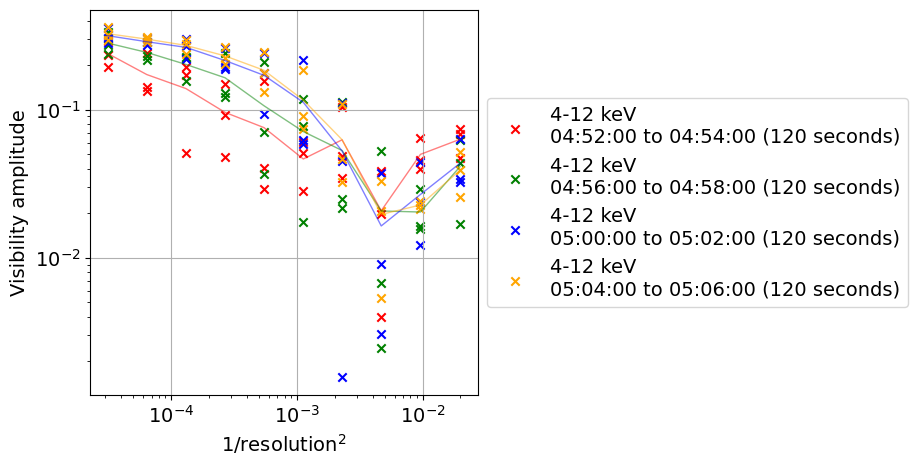

In [23]:

energy_range = [4,12]

markers = ["2021-07-17 04:52:00","2021-07-17 04:54:00"]
v1 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

markers = ["2021-07-17 04:56:00","2021-07-17 04:58:00"]
v2 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

markers = ["2021-07-17 05:00:00","2021-07-17 05:02:00"]
v3 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

markers = ["2021-07-17 05:04:00","2021-07-17 05:06:00"]
v4 = create_modulation_data(pixeldata,pixel_energies,energy_range,markers)

plot_visibilities([v1,v2,v3,v4],normed=True)

#### To think about...
* How is the source scale evolving in time? 